# Insect detector
YOLO network trained to detect a) the presence and b) the bounding boxes of insects in images and videos.

# Step 1 Setup

## STEP 1.1 Connect the Colab notebook to Google Drive

In [0]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## STEP 1.2 Copy darknet to notebook for execution

In [0]:
# Makes a dir for darknet and move there
!mkdir /content/darknet
!mkdir /content/data
!mkdir /content/meta
!mkdir /content/temp
%cd /content/darknet

# Copy the Darkent compiled version to the VM local drive
!cp /content/gdrive/My\ Drive/darknet/bin/darknet .

# Set execution permissions to Darknet
!chmod +x ./darknet


/content/darknet


## STEP 1.3 Install Insects Client

In [0]:
%%capture
!pip install git+https://github.com/LBrinkmann/insects-client.git
import os
os.environ['INSECTS_PLATFORM_URL'] = 'http://195.201.97.57:5000'

## STEP 1.4 Define utility functions

In [0]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# STEP 2 Import data from the Insects Monitoring Lab

In [0]:
from insectsclient import api

_, frame_paths = api.import_collection(45, '/content/data', with_appearances_only=False)
data_41 = api.create_file_list(frame_paths, '/content/data/coll41.txt')


100% (837 of 837) |######################| Elapsed Time: 0:12:44 Time:  0:12:44


# STEP 3 Setup Predictions

In [0]:
from insectsclient import darknet
d = {
    "classes": 1,
    "names": '/content/meta2/obj.names'
}
!mkdir '/content/meta2/'

labels = [{'scientificName':'acheta domesticus', 'id': 13}]

DATA = darknet.create_data(d, '/content/meta2/')
darknet.create_names(labels, '/content/meta2/')

'/content/meta2/obj.names'

## STEP 3.1 Check if everything is ready for training

In [0]:
# all models
!ls '/content/gdrive/My Drive/darknet/models'

full
insects_yolov3_4000_crickets200.weights
insects_yolov3_final_fulldataset.weights
insects_yolov3-tiny_4000_crickets200.weights
insects_yolov3-tiny_final_fulldataset.weights
insects_yolov3-tiny_final_smalldataset.weights
README.md
tiny


In [0]:
# MODEL="/content/gdrive/My\ Drive/darknet/cfg/insects_yolov3-tiny.cfg"
# WEIGHTS='/content/gdrive/My\ Drive/darknet/models/insects_yolov3-tiny_final_fulldataset.weights'
# WEIGHTS='/content/gdrive/My\ Drive/darknet/models/insects_yolov3-tiny_4000_crickets200.weights'

MODEL="/content/gdrive/My\ Drive/darknet/cfg/insects_yolov3.cfg"
# WEIGHTS='/content/gdrive/My\ Drive/darknet/models/insects_yolov3_final_fulldataset.weights'
WEIGHTS='/content/gdrive/My\ Drive/darknet/models/insects_yolov3_4000_crickets200.weights'



In [0]:
# check if all files exists in the correct place
%cd /content/darknet/

!ls darknet

!ls $WEIGHTS  # pre-trained start weights
!ls $MODEL  # network configuration file
!ls $DATA  # data and classification problem configuration file
!ls '/content/meta/obj.names'  # class name
!ls '/content/meta/test.txt'  # list of test images
!ls '/content/meta/train.txt'  # list of train images
!ls '/content/temp'  # where to save the check-points and winal weights
!head -n2 '/content/meta/test.txt'
!head -n2 '/content/meta/train.txt'


/content/darknet
darknet
'/content/gdrive/My Drive/darknet/models/insects_yolov3_4000_crickets200.weights'
'/content/gdrive/My Drive/darknet/cfg/insects_yolov3.cfg'
/content/meta2/obj.data
ls: cannot access '/content/meta/obj.names': No such file or directory
ls: cannot access '/content/meta/test.txt': No such file or directory
ls: cannot access '/content/meta/train.txt': No such file or directory
head: cannot open '/content/meta/test.txt' for reading: No such file or directory
head: cannot open '/content/meta/train.txt' for reading: No such file or directory


In [0]:
!tail '/content/meta/obj.data'

tail: cannot open '/content/meta/obj.data' for reading: No such file or directory


In [0]:
!tail '/content/meta/obj.names'

tail: cannot open '/content/meta/obj.names' for reading: No such file or directory


# STEP 4 Apply Model

## STEP 4.1 On single image

In [0]:
!echo $DATA $MODEL $WEIGHTS

/content/meta2/obj.data /content/gdrive/My Drive/darknet/cfg/insects_yolov3.cfg /content/gdrive/My Drive/darknet/models/insects_yolov3_4000_crickets200.weights


rm: cannot remove 'predictions.jpg': No such file or directory


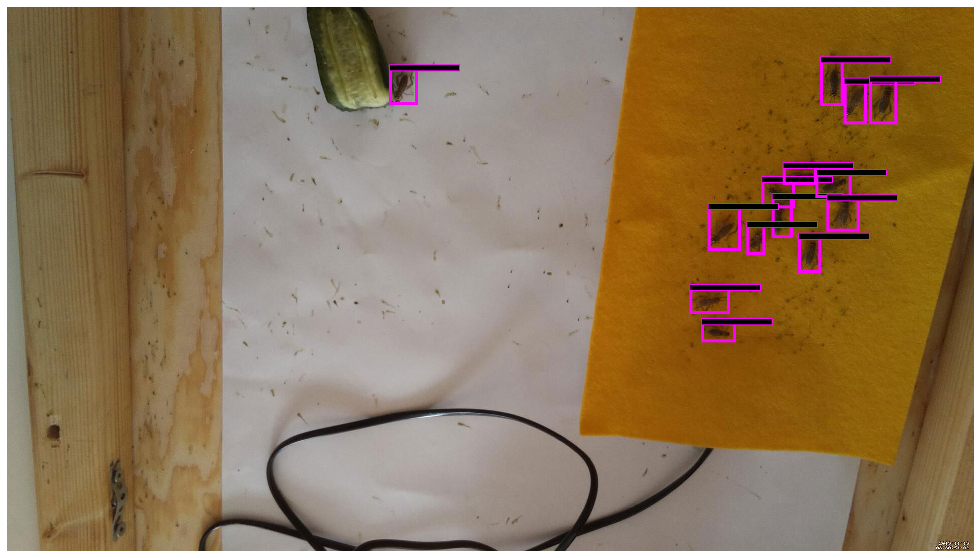

In [0]:
# copy required names files (path seems to be hard-coded into executable)
frame_path = frame_paths[5]['path']
!rm 'predictions.jpg'

# tryout resulting network (insects)
!./darknet detector test $DATA $MODEL $WEIGHTS $frame_path -thresh 0.25 --dont-show  > /dev/null 2>&1

# Show the result using the helper imgShow()
imShow('predictions.jpg')

## STEP 4.1 On all images

In [0]:
!./darknet detector test $DATA $MODEL $WEIGHTS -thresh 0.25 -d  §ont_show -save_labels < $data_41 > /dev/null 2>&1

## STEP 5 Upload Annotations back

In [0]:
api.upload_appearances(frame_paths, labels, 5)

Successfully uploaded 4731 appearances
